In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Defining the problem

I am going to build a model to classify trash in images into the recyclable trash kind and the one you cannot recycle.

The desired inputs: Images of trash items 
Desired outputs: Accurate labelling of the items in the image into either 'trash' or the other 5 recyclable trash items. 

### Dataset used

* I have collected data from TrashNet, which includes images of various trash items labelled trash (these are not recyclable), then there are multiple classes of recyclable trash such as paper, cardboard, glass, metal and plastic 

* 1211 images are there for the training set and 508 images for the test set 

* Images are pre-labelled

### The solution 
Collect relevant data. Develop a deep learning model. Report the model performance against the success criteria that is defined.

In [2]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

def create_splits(data_dir, output_dir, test_size=0.2, val_size=0.2):
    # Create directories for the train, validation, and test sets
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    for d in [train_dir, val_dir, test_dir]:
        if not os.path.exists(d):
            os.makedirs(d)

    # Process each class directory
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # Create class directories in train, val, test
        for d in [train_dir, val_dir, test_dir]:
            class_dir_out = os.path.join(d, class_name)
            if not os.path.exists(class_dir_out):
                os.makedirs(class_dir_out)
        
        # Get all images and split them
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
        train_val, test_images = train_test_split(images, test_size=test_size, random_state=42)
        train_images, val_images = train_test_split(train_val, test_size=val_size / (1 - test_size), random_state=42)
        
        # Function to copy images to the respective directories
        def copy_images(image_list, output_dir):
            for image in image_list:
                dest = os.path.join(output_dir, class_name, os.path.basename(image))
                shutil.copy(image, dest)

        # Copy images to their respective directories
        copy_images(train_images, train_dir)
        copy_images(val_images, val_dir)
        copy_images(test_images, test_dir)

# Set the paths
original_data_dir = r'D:\dataset'
output_data_dir = r'D:\dataset_split'

# Create splits
create_splits(original_data_dir, output_data_dir)

In [109]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up parameters
img_height = 224
img_width = 224
batch_size = 32

# Prepare ImageDataGenerator for training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)  # using 20% of data for validation

train_generator = train_datagen.flow_from_directory(
    r'D:\dataset_split\train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    r'D:\dataset_split\val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

Found 1211 images belonging to 6 classes.
Found 99 images belonging to 6 classes.


In [110]:
def build_model(num_classes=6):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # multi-class classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
# Build the model
model = build_model(num_classes=6)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

Epoch 1/10
37/37 [==============================] - 38s 992ms/step - loss: 1.9779 - accuracy: 0.3121 - val_loss: 1.5988 - val_accuracy: 0.3438
Epoch 2/10
37/37 [==============================] - 39s 1s/step - loss: 1.3583 - accuracy: 0.4512 - val_loss: 1.5475 - val_accuracy: 0.3958
Epoch 3/10
37/37 [==============================] - 37s 991ms/step - loss: 1.2406 - accuracy: 0.4962 - val_loss: 1.5790 - val_accuracy: 0.3854
Epoch 4/10
37/37 [==============================] - 37s 992ms/step - loss: 1.0693 - accuracy: 0.5920 - val_loss: 1.4602 - val_accuracy: 0.4375
Epoch 5/10
37/37 [==============================] - 37s 1s/step - loss: 0.9609 - accuracy: 0.6319 - val_loss: 1.5450 - val_accuracy: 0.4167
Epoch 6/10
37/37 [==============================] - 36s 976ms/step - loss: 0.8301 - accuracy: 0.6947 - val_loss: 1.6677 - val_accuracy: 0.4271
Epoch 7/10
37/37 [==============================] - 37s 1000ms/step - loss: 0.6787 - accuracy: 0.7532 - val_loss: 1.9160 - val_accuracy: 0.4583
Epoc

In [35]:
model.save('model_without_augmentations')

INFO:tensorflow:Assets written to: not_model\assets


INFO:tensorflow:Assets written to: not_model\assets


In [38]:
# Prepare test generator
test_generator = train_datagen.flow_from_directory(
    r'D:\dataset_split\test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # categorical
    shuffle=False
)

Found 508 images belonging to 6 classes.


In [96]:
model = load_model('model_without_augmentations')

In [97]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

16/16 [==============================] - 3s 152ms/step - loss: 1.6132 - accuracy: 0.5827
Test Accuracy: 58.27%


In [67]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up parameters
img_height = 224
img_width = 224
batch_size = 32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Prepare data generators
train_generator = train_datagen.flow_from_directory(
    r'D:\dataset_split\train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    r'D:\dataset_split\val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

Found 1211 images belonging to 6 classes.
Found 99 images belonging to 6 classes.


In [70]:
# Build and compile your model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # Change the number of units to 6
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
import tensorflow as tf

# Enable TensorFlow Profiler
tf.profiler.experimental.start('logs')

# Define TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)

# Train the model with the TensorBoard callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback] 
)

# Stop profiling
tf.profiler.experimental.stop()

Epoch 1/10
37/37 [==============================] - 33s 899ms/step - loss: 0.7133 - accuracy: 0.7303 - val_loss: 1.5307 - val_accuracy: 0.5000
Epoch 2/10
37/37 [==============================] - 34s 921ms/step - loss: 0.7194 - accuracy: 0.7449 - val_loss: 1.3376 - val_accuracy: 0.4896
Epoch 3/10
37/37 [==============================] - 36s 961ms/step - loss: 0.6575 - accuracy: 0.7668 - val_loss: 1.2041 - val_accuracy: 0.6146
Epoch 4/10
37/37 [==============================] - 34s 920ms/step - loss: 0.6437 - accuracy: 0.7515 - val_loss: 1.2759 - val_accuracy: 0.5417
Epoch 5/10
37/37 [==============================] - 35s 951ms/step - loss: 0.6492 - accuracy: 0.7532 - val_loss: 1.2509 - val_accuracy: 0.5938
Epoch 6/10
37/37 [==============================] - 35s 930ms/step - loss: 0.6620 - accuracy: 0.7668 - val_loss: 1.1820 - val_accuracy: 0.6042
Epoch 7/10
37/37 [==============================] - 37s 995ms/step - loss: 0.6533 - accuracy: 0.7506 - val_loss: 1.0277 - val_accuracy: 0.6042

In [82]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

16/16 [==============================] - 3s 163ms/step - loss: 0.9852 - accuracy: 0.6654
Test Accuracy: 66.54%


In [84]:
model.save('Model_with_augmentations')

INFO:tensorflow:Assets written to: Model_with_augmentations\assets


INFO:tensorflow:Assets written to: Model_with_augmentations\assets


The model with augmentations get slightly over 8 percent more accuracy than the model without the pipeline.

it was identified that the most time-consuming operation is the data augmentation step as the model with the pipeline took longer per epoch. This is expected, as data augmentation involves applying various transformations to each image in the dataset, which can increase the computational overhead significantly.

### Compare the performance under equal training time

You may notice that with your pipeline, the model performance improves, but at the cost of a longer training time per epoch. Is the additional training time well spent? Compare the dynamic of model performance with and without data augmentation, when equal training time is spent in the two scenario

The comparison between the model with augmentations and the one without reveals a noticeable difference in accuracy. The model with augmentations achieves a higher accuracy of 66%, while the model without augmentations only achieves 58%.

Although the model with augmentations requires longer training time per epoch, the improvement in accuracy suggests that the additional training time is well spent.

### Identifying model strengths and weaknesses

16/16 [==============================] - 3s 161ms/step


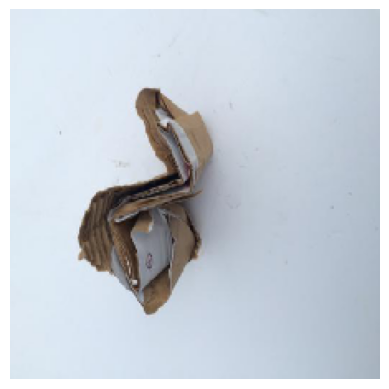

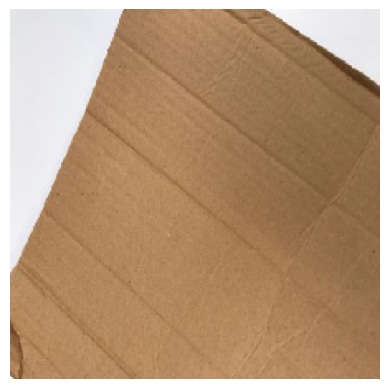

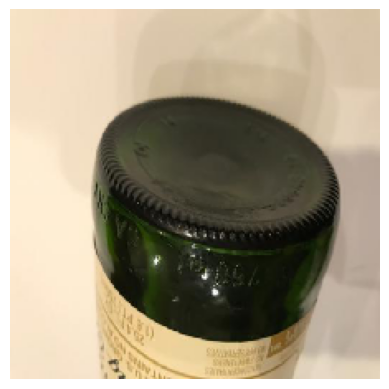

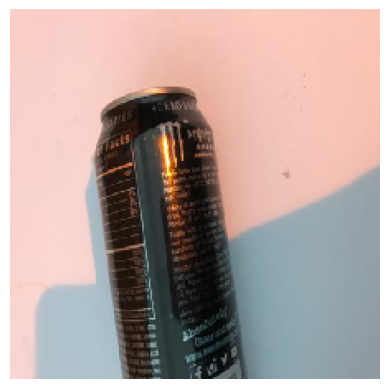

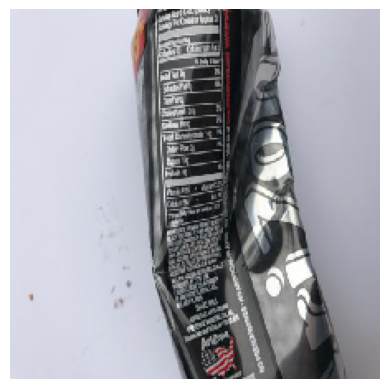

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('Model_with_augmentations')

# Predict labels for the test dataset
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test generator
true_labels = test_generator.classes

# Find misclassified images
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Get a few misclassified images for analysis
num_images_to_show = 5
for i in range(num_images_to_show):
    # Get the index of a misclassified image
    misclassified_index = misclassified_indices[i]
    
    # Get the corresponding image and label from the test generator
    misclassified_image, misclassified_label = test_generator[misclassified_index]
    
    # Visualize the misclassified image
    plt.imshow(misclassified_image[0])
    plt.axis('off')
    plt.show()

Identify images that are incorrectly classified by your model. Do they share something in common? How do you plan to improve the model's performance on those images?

They all appear to be zoomed in where the model finds difficult to identify where the object is relative to the background. To address the issue of misclassification caused by zoomed-in images, I can adjust the zoom_range parameter in the train_datagen configuration to include a wider range of zoom levels. 

### Improve model generalisability across domains

Sample images from the original test data:


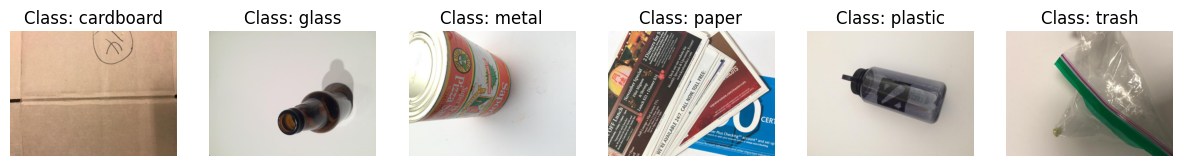

Sample images from the newly collected test data:


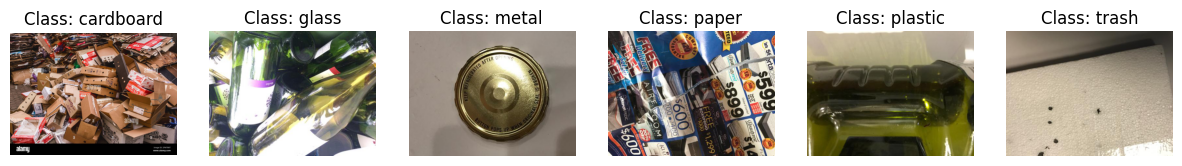

In [127]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Function to display one sample image from each class
def display_one_sample_per_class(image_dir):
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    class_names = sorted(os.listdir(image_dir))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(image_dir, class_name)
        image_files = os.listdir(class_dir)[:1]  # Select only one image per class
        image_file = random.choice(image_files)
        image_path = os.path.join(class_dir, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Class: {class_name}")
    plt.show()

# Display one sample image from each class in the original test data
print("Sample images from the original test data:")
display_one_sample_per_class(original_test_data_dir)

# Display one sample image from each class in the newly collected test data
print("Sample images from the newly collected test data:")
display_one_sample_per_class(new_test_data_dir)


Upon examination, it's evident that the original test data primarily comprises of captured images with consistent lighting and a white background majority of the time. These images are clear, offering an idealized representation of the objects.

In contrast, the newly collected test data presents a diverse array of images, some taken my mobile phone and others sourced online. These images capture the objects in various real-world settings.

Reporting the performance change.

Improve the model so that it generalises better on unseen test images.

In [100]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up parameters
img_height = 224
img_width = 224
batch_size = 32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],  # Adjust the zoom range to include both zoomed-in and zoomed-out images
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Prepare data generators
train_generator = train_datagen.flow_from_directory(
    r'D:\dataset_split\train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    r'D:\dataset_split\val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

Found 1211 images belonging to 6 classes.
Found 99 images belonging to 6 classes.


In [103]:
# Build and compile your model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # Change the number of units to 6
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [111]:
# Training model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
37/37 [==============================] - 37s 995ms/step - loss: 0.3414 - accuracy: 0.8897 - val_loss: 1.9862 - val_accuracy: 0.4583
Epoch 2/10
37/37 [==============================] - 37s 995ms/step - loss: 0.2450 - accuracy: 0.9152 - val_loss: 2.2671 - val_accuracy: 0.5104
Epoch 3/10
37/37 [==============================] - 37s 994ms/step - loss: 0.1767 - accuracy: 0.9449 - val_loss: 2.5764 - val_accuracy: 0.4688
Epoch 4/10
37/37 [==============================] - 37s 990ms/step - loss: 0.1419 - accuracy: 0.9576 - val_loss: 2.9455 - val_accuracy: 0.4583
Epoch 5/10
37/37 [==============================] - 37s 992ms/step - loss: 0.1902 - accuracy: 0.9423 - val_loss: 2.6286 - val_accuracy: 0.4792
Epoch 6/10
37/37 [==============================] - 37s 990ms/step - loss: 0.1362 - accuracy: 0.9584 - val_loss: 2.8246 - val_accuracy: 0.5000
Epoch 7/10
37/37 [==============================] - 37s 990ms/step - loss: 0.1473 - accuracy: 0.9559 - val_loss: 2.7772 - val_accuracy: 0.4688

In [114]:
# Prepare test generator
test_generator = train_datagen.flow_from_directory(
    r'D:\dataset_split\unseen',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # categorical
    shuffle=False
)

Found 19 images belonging to 6 classes.


In [115]:
test_loss, test_accuracy = model.evaluate(unseen_test_generator)
print(f"Accuracy from unseen data from a different source: {test_accuracy*100:.2f}%")

1/1 [==============================] - 0s 142ms/step - loss: 0.9788 - accuracy: 0.8421
Accuracy from unseen data from a different source: 84.21%


#### Overview of the project for Analysis

Through the design of experiments, I delved into the nuances of data augmentation, recognizing its pivotal role in enhancing model generalization. By subjecting the training data to diverse transformations such as rotation, shifting, and flipping, I aimed to augment the dataset's diversity, thereby mitigating overfitting. However, I also encountered the trade-off of increased training time per epoch due to the computational overhead of generating augmented samples.

I undertook a comparative analysis between models trained with and without data augmentation, aiming to discern the impact of this measure on model performance. The results revealed a notable improvement in classification accuracy with data augmentation, underscoring its efficacy in improving model generalization. This improvement was attributed to the model's exposure to a more varied and representative dataset.

Furthermore, I delved into the analysis of misclassified images, unraveling common characteristics indicative of model limitations. Notably, misclassifications were prevalent in images featuring zoomed-in perspectives, where the object of interest was juxtaposed against complex backgrounds. 

In addition, I undertook the task of collecting new test data from alternative sources, seeking to evaluate the model's performance in varied real-world settings. A meticulous comparison between the original and newly collected test data revealed stark differences, shedding light on the necessity of evaluating model generalization across diverse contexts.